# Feature Engineering

This notebook demonstrates feature engineering for solar power forecasting.
We will use the cleaned dataset, apply cyclic encoding, and prepare features for modeling.

#### Feature Engineering Strategy Overview

The feature engineering process is designed to create informative, non-leaky features for solar power forecasting, following these principles:
- Use only historical and present information (no future leakage)
- Encode temporal cycles (hour, day of year) to help the model learn periodic patterns
- Retain key solar and weather features
- Avoid over-engineering or introducing unnecessary complexity

Below, we explain each transformation and decision in detail.

#### Cyclic Encoding of Temporal Features

Solar generation is highly dependent on time of day and season. To help the model learn these periodic patterns, we apply **cyclic encoding** to:
- `first_hour_of_period` (hour of day, range 0-23)
- `day_of_year` (range 1-366)

Cyclic encoding transforms these features into sine and cosine components, preserving their circular nature (e.g., hour 23 is next to hour 0). This prevents artificial discontinuities and improves model performance for time-based patterns.

**Example:**
- For hour: `hour_sin = sin(2π * hour / 24)`, `hour_cos = cos(2π * hour / 24)`
- For day of year: `day_sin = sin(2π * day / 366)`, `day_cos = cos(2π * day / 366)`

#### Additional Feature Engineering Decisions

- **Is Daylight:**
  - Kept as a binary feature (0 = night, 1 = daylight) to indicate whether the sun is above the horizon. This is a strong predictor for solar generation and is safe to use (no leakage).
  - Any missing values are filled with 0 (assume night if unknown).

- **Distance to Solar Noon:**
  - The squared value (`distance_to_noon_squared`) is added to capture the non-linear effect of time from solar noon on generation.

- **Solar Potential:**
  - A custom feature combining sky cover and distance to solar noon:

      `(1 - sky_cover / 100) × (1 - distance_to_solar_noon / max(distance_to_solar_noon))`

    This approximates the theoretical potential for solar generation, considering both cloudiness and sun position.

- **Dropping Redundant Columns:**
  - After encoding, we drop columns like `year`, `month`, `day`, and `first_hour_of_period` to avoid redundancy and multicollinearity.
  - The target column (`power_generated_kw`) is always retained.

All transformations are performed in a way that prevents data leakage and follows best practices for time series regression.

#### Feature Engineering Summary

- **Cyclic encoding** is used for temporal features to capture daily and yearly cycles.
- **Is Daylight** is retained as a binary indicator, crucial for solar prediction.
- **Distance to solar noon** and its square help model the sun's position effect.
- **Solar potential** combines sky cover and sun position for a physically meaningful feature.
- **Redundant columns** are dropped to keep the feature set clean and avoid multicollinearity.

All steps are implemented in `features.py` for reproducibility and production use. This ensures the same logic is applied in both experimentation and the final pipeline.

### 1. Import Required Libraries

We import pandas, numpy, and the feature engineering functions from features.py.

In [17]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../src'))
from features import load_data, feature_engineering

### 2. Feature Engineering Functions (from features.py)

Reusable feature engineering functions are implemented in features.py. See code in the src directory.

### 3. Load Cleaned Dataset

Load the cleaned data produced by preprocessing.py.

In [18]:
# Load cleaned data
df = load_data('../data/processed/solar_clean.csv')
df.head()

,day_of_year,year,month,day,first_hour_of_period,is_daylight,distance_to_solar_noon,average_temperature_day,average_wind_direction_day,average_wind_speed_day,sky_cover,visibility,relative_humidity,average_wind_speed_period,average_barometric_pressure_period,power_generated_kw
0,245,2008,9,1,1,0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,245,2008,9,1,4,0,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,245,2008,9,1,7,1,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,1,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,1,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


### 4. Apply Feature Engineering Functions

Transform the dataset using the feature_engineering function.

In [19]:
# Apply feature engineering
df_features = feature_engineering(df.copy())
df_features.head()

,day_of_year,is_daylight,distance_to_solar_noon,average_temperature_day,average_wind_direction_day,average_wind_speed_day,sky_cover,visibility,relative_humidity,average_wind_speed_period,average_barometric_pressure_period,power_generated_kw,first_hour_of_period_sin,first_hour_of_period_cos,day_of_year_sin,day_of_year_cos,distance_to_noon_squared,solar_potential
0,245,0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0,0.258819,0.965926,-0.874481,-0.48506,0.739423,0.246604
1,245,0,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0,0.866025,0.500000,-0.874481,-0.48506,0.395056,0.449311
2,245,1,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418,0.965926,-0.258819,-0.874481,-0.48506,0.157746,0.652019
3,245,1,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477,0.500000,-0.866025,-0.874481,-0.48506,0.027493,0.854726
4,245,1,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069,-0.258819,-0.965926,-0.874481,-0.48506,0.004297,0.942566


### 5. Explore Engineered Features

Display and analyze the new features. Visualize cyclic encodings for a few samples.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Show feature columns
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
day_of_year,2920.0,1.833342e+02,105.769919,1.000000,92.000000,1.830000e+02,275.000000,366.000000
is_daylight,2920.0,6.181507e-01,0.485923,0.000000,0.000000,1.000000e+00,1.000000,1.000000
distance_to_solar_noon,2920.0,5.032940e-01,0.298024,0.050401,0.243714,4.789569e-01,0.739528,1.141361
average_temperature_day,2920.0,5.846849e+01,6.841200,42.000000,53.000000,5.900000e+01,63.000000,78.000000
average_wind_direction_day,2920.0,2.495342e+01,6.915178,1.000000,25.000000,2.700000e+01,29.000000,36.000000
average_wind_speed_day,2920.0,1.009699e+01,4.838185,1.100000,6.600000,1.000000e+01,13.100000,26.600000
sky_cover,2920.0,1.987671e+00,1.411978,0.000000,1.000000,2.000000e+00,3.000000,4.000000
visibility,2920.0,9.557705e+00,1.383884,0.000000,10.000000,1.000000e+01,10.000000,10.000000
relative_humidity,2920.0,7.351370e+01,15.077139,14.000000,65.000000,7.700000e+01,84.000000,100.000000
average_wind_speed_period,2920.0,1.012877e+01,7.260333,0.000000,5.000000,9.000000e+00,15.000000,40.000000


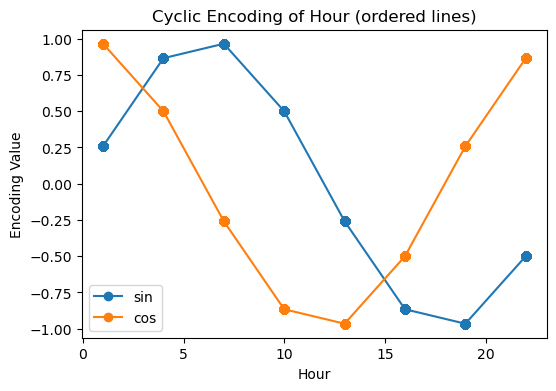

In [21]:
# Function to plot cyclic encoding with lines joining the points in order of hour

def plot_cyclic_encoding_with_lines_sorted(x, y_sin, y_cos):
    import matplotlib.pyplot as plt
    import numpy as np
    # Sort by x to ensure lines are drawn in order
    sort_idx = np.argsort(x)
    x_sorted = np.array(x)[sort_idx]
    y_sin_sorted = np.array(y_sin)[sort_idx]
    y_cos_sorted = np.array(y_cos)[sort_idx]
    plt.figure(figsize=(6,4))
    plt.plot(x_sorted, y_sin_sorted, label="sin", marker="o")
    plt.plot(x_sorted, y_cos_sorted, label="cos", marker="o")
    plt.title("Cyclic Encoding of Hour (ordered lines)")
    plt.xlabel("Hour")
    plt.ylabel("Encoding Value")
    plt.legend()
    plt.show()

# Example usage:
plot_cyclic_encoding_with_lines_sorted(
    df["first_hour_of_period"],
    df_features["first_hour_of_period_sin"],
    df_features["first_hour_of_period_cos"]
)

### 6. Save Engineered Features

Save the engineered features to a new CSV for modeling.

In [22]:
# Save engineered features
# df_features.to_csv('../data/processed/solar_features.csv', index=False)
print('Saved engineered features to ../data/processed/solar_features.csv')

Saved engineered features to ../data/processed/solar_features.csv
